<a href="https://colab.research.google.com/github/natrask/ENM1050/blob/main/roughClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 17 - Pandas and a cookbook for a data-gathering/classification pipeline** #

# CONTRIBUTORS #

This in-class exercise is to be done in pairs. Add the names of the two students in this text block.


# Overview of today #

Today we are going to be processing *geospatial data* - data that describes the position of a sensor on the globe. To do that, we will need a library that doesn't come installed by default in colab, called *geopandas*. Pandas, and geopandas, are both libraries for easily handling data, and act as a simple layer between the data and pytorch that will make our life easier.

First, we will tell colab to install geopandas and contextily. This will take a minute.

In [61]:
# First, here is a list of libraries that we'll need.

!pip install geopandas contextily

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

Next we will see an example of what kind of processing geopandas allows us to do.

A pandas dataframe (pd.DataFrame) holds different types of data. In the short example below, it holds data corresponding to address, latitude, and longitude for two different addresses.

By wrapping it in a GeoDataFrame, we are specifying which parts of the data correspond to a geometric data point, and specify a coordinate system (in this case something called EPSG:4326). We use this to render the two points on a map of Philadelphia.

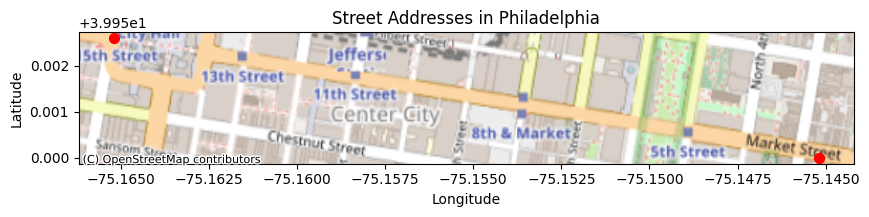

In [62]:
# Replace with your actual data
# Assuming you have a CSV file with 'address' and 'latitude', 'longitude' columns
data = pd.DataFrame({'address': ['123 Market St, Philadelphia, PA', '456 Walnut St, Philadelphia, PA'],
                     'latitude': [39.9526, 39.9500],
                     'longitude': [-75.1652, -75.1452]})

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf.crs = 'EPSG:4326'  # Set the coordinate system to WGS 84

# Plot the map
ax = gdf.plot(figsize=(10, 10), markersize=50, color='red')

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot (optional)
plt.title('Street Addresses in Philadelphia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In general, geospatial data can come from many sources. As we transition to working with robots and sensors in the remainder of the course, we will see that it is easy to extract latitude and longitude with a small sensor. This can be used to assist in robotic navigation, or track the location of a passive sensor (like a weather balloon) as it drifts around in the atmosphere. If other information is gathered at the same site (for example, temperature/humidity for a weather sensor), then we can attempt to use machine learning to associate measurements with either classification or prediction.

**Today's goal:** we will build up a model of the Penn campus that aims to identify what parts of campus are primarily residential vs academic.

# Introducing Pandas #

Before we do that, I'm going to introduce Pandas. Pandas makes it easy to explore very large datasets. For many datasets that you would receive in practice, they would likely come prepackaged as a pandas dataframe. In this first example, we will generate a dataframe describing four people and some demographics about them.

In [64]:
import pandas as pd

# Creating a DataFrame from a dictionary
data = {'Name': ['Alice', 'Bob', 'Charlie', 'Dennis'],
        'Age': [25, 30, 22, 18],
        'City': ['New York', 'London', 'Paris', 'Philadelphia'],
        'Income': [96000,55327,101101,42000]}
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

      Name  Age          City  Income
0    Alice   25      New York   96000
1      Bob   30        London   55327
2  Charlie   22         Paris  101101
3   Dennis   18  Philadelphia   42000


The following sets of functions show how pandas let's use easily manipulate the data, gather subsets of the data, and summarize trends in the dataset.

In [65]:

# Accessing columns
print('The follow is the names in the dataset')
print(df['Name'])  # Accessing the 'Name' column
print('\n')

# Accessing rows by index
print('This is the first entry in the dataset')
print(df.loc[0])  # Accessing the first row
print('\n')

# # Filtering data
print('The following lists entries only over the age of 25:')
print(df[df['Age'] > 25])  # Filtering rows where 'Age' is greater than 25
print('\n')

# Adding a new column
print('We can add a new column - in this case the country for each')
df['Country'] = ['USA', 'UK', 'France','USA']
print(df)
print('\n')

# It is easy to grab simple properties
print('The average age by country is:')
print(df.groupby('Country')['Age'].mean())  # Grouping by 'Country' and calculating the mean of 'Age'

# # Some other useful methods:
# print(df.describe())  # Summary statistics of numerical columns
# print(df.head(2))  # Displaying the first 2 rows
# print(df.tail(2))  # Displaying the last 2 rows
# print(df.sort_values(by='Age'))  # Sorting by 'Age'



The follow is the names in the dataset
0      Alice
1        Bob
2    Charlie
3     Dennis
Name: Name, dtype: object


This is the first entry in the dataset
Name         Alice
Age             25
City      New York
Income       96000
Name: 0, dtype: object


The following lists entries only over the age of 25:
  Name  Age    City  Income
1  Bob   30  London   55327


We can add a new column - in this case the country for each
      Name  Age          City  Income Country
0    Alice   25      New York   96000     USA
1      Bob   30        London   55327      UK
2  Charlie   22         Paris  101101  France
3   Dennis   18  Philadelphia   42000     USA


The average age by country is:
Country
France    22.0
UK        30.0
USA       21.5
Name: Age, dtype: float64


Remember when using a new library to use Gemini! It won't be able to do your homework for you, but you can ask it to explain any one of these functions.

**Your turn:** Ask gemini to explain df.groupby('Country')['Age']. Paste your explanation in the block below.

*Put stuff here.*

# Today's exercise - a complete data collection to ML pipeline #

In the last lecture we discussed *decision boundaries*. These are geometric boundaries that a classification model uses to assign each datapoint to a class. For example, if you wanted to classify a child as a newborn or an toddler, one could look at the childs weight and height as a clear indicator. We saw this last lecture as we used flower stems and petals as a way to identify flower species.

Today we will develop a system that will split the Penn campus up into residential and non-residential areas. To do this, we will generate a list of latitude/longitude locations of buildings and label them as either a *dorm* or an *academic building* (meaning a lecture hall, laboratory, etc).

We will do this by constructing a google form. The reason for this is that in your next HW assignment you will build a survey to collect data to perform a classification analysis, and you will be able to use this exercise with minor changes.

**Your turn.**
1. Open maps.google.com and search for the UPenn campus.
2. Choose a random dorm on campus (doesn't need to be yours). Right click it on the google map to get a longitude and latitude.
3. Open up the following survey: https://forms.gle/TZ5gedEEHYo9wGmB6
4. Enter the longitude and latitude, and mark as a *dorm*.
5. Repeat the process but for a random academic building, and mark as a *not dorm*.

# Process dataset into a pandas dataframe #

In what's below, we will load in the output of the survey from a corresponding googlesheet, and put it into a pandas dataframe.

In [80]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [81]:
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1PNweaNkwxdmCo84-1duahGVg1uelcsSS0ZaL45EVIiY/edit?gid=1824420767#gid=1824420767'
sh = gc.open_by_url(spreadsheet_url)  # or gc.open_by_key(spreadsheet_key)
worksheet = sh.get_worksheet(0)

From early in the semester, we had shown how we could loop over and process that data using lists. For example:

In [82]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()
for entry in range(1,len(data)):
  lat_entry = data[entry][1]
  lon_entry = data[entry][2]
  if data[entry][3] == 'Dorm':
    label_entry = 1
  else:
    label_entry = 0

  print(lat_entry,lon_entry,label_entry)

39.95308 -75.19249 0
39.95205 -75.1979 0
39.95225 -75.19266 0
39.95366 -75.19132 1
39.95188 -75.20233 1
39.95232 -75.20021 1
39.95189812 -75.2023688 1
39.95272544 -75.19714167 0
39.95238572 -75.20015407 1
39.95241348 -75.19001522 0
39.95299722 -75.19091083 1
39.9509484 -75.1948328 0
39.95330201 -75.20134244 1
39.95083068 -75.19204164 0
39.95233374 -75.20016061 1
39.95026 -75.19606 1
39.9542 -75.1945 1
39.95198414 -75.18984774 0
39.95379933 -75.20101018 1
39.95186818 -75.20255606 1
39.9538 -75.20249 1
39.95365561 -75.20257609 1
39.9542 -75.19405 1
39.952997 -75.191 1
39.95240217 -75.20018626 1
39.950814 -75.197476 1
39.95282017 -75.1997718 0
39.95228 -75.18976 0
39.95207 -75.18988 0
39.95356 -75.20252 1
39.95213179 -75.19781213 0
39.95127647 -75.19130059 0
39.953 -75.19066 1
39.9518504 -75.20223356 1
39.95316964 -75.20133003 1
39.95297248 -75.19070835 1
39.95361 -75.19132 1
39.950495 -75.197855 1
39.95265 -75.19355 0
39.953196 -75.195788 0
39.95314305 -75.20138936 1
39.95045064 -75.1977

To instead stick it in a dataframe, we first define a list of strings defining the types of data in columns, and then loop through the data pushing new entries into the database one at a time.

In [83]:
import pandas as pd

# Create an empty DataFrame with specified column names
columns = ['latitude', 'longitude', 'survey_label']
df = pd.DataFrame(columns=columns)

# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()
for entry in range(1,len(data)):
  lat_entry = float(data[entry][1])
  lon_entry = float(data[entry][2])
  if data[entry][3] == 'Dorm':
    label_entry = 1
  else:
    label_entry = 0

  df.loc[len(df)] = [lat_entry, lon_entry, label_entry]

The following shows how easy it is now to pull out arrays corresponding to different pairs of values.

In [84]:
print('We can pull out pairs of latitude and longitude by listing column names in square brackets')
print(df[['latitude','longitude']])
print('\n')

print('We can pull these out in numpy format by appending .values at the end.')
print(df[['latitude','longitude']].values)
print('\n')

We can pull out pairs of latitude and longitude by listing column names in square brackets
     latitude  longitude
0   39.953080 -75.192490
1   39.952050 -75.197900
2   39.952250 -75.192660
3   39.953660 -75.191320
4   39.951880 -75.202330
5   39.952320 -75.200210
6   39.951898 -75.202369
7   39.952725 -75.197142
8   39.952386 -75.200154
9   39.952413 -75.190015
10  39.952997 -75.190911
11  39.950948 -75.194833
12  39.953302 -75.201342
13  39.950831 -75.192042
14  39.952334 -75.200161
15  39.950260 -75.196060
16  39.954200 -75.194500
17  39.951984 -75.189848
18  39.953799 -75.201010
19  39.951868 -75.202556
20  39.953800 -75.202490
21  39.953656 -75.202576
22  39.954200 -75.194050
23  39.952997 -75.191000
24  39.952402 -75.200186
25  39.950814 -75.197476
26  39.952820 -75.199772
27  39.952280 -75.189760
28  39.952070 -75.189880
29  39.953560 -75.202520
30  39.952132 -75.197812
31  39.951276 -75.191301
32  39.953000 -75.190660
33  39.951850 -75.202234
34  39.953170 -75.201330
35  39.95

**Your turn.** Modify the code in the above block to print out a numpy array corresponding to:
1. just latitudes
2. latitudes and label_entry
3. latitutude, longitudes, and label_entry

In [85]:
# Put stuff here

## PyTorch cookbook step 1 - Load data ##

First we will visualize the data. This is where we need to use gpd. Don't work about the details of this, although you can click the Gemini button in the top right of colab and ask Gemini to "explain what a geodataframe is" to learning more. For now though, you can take this as a visualization showing where we have collected data.

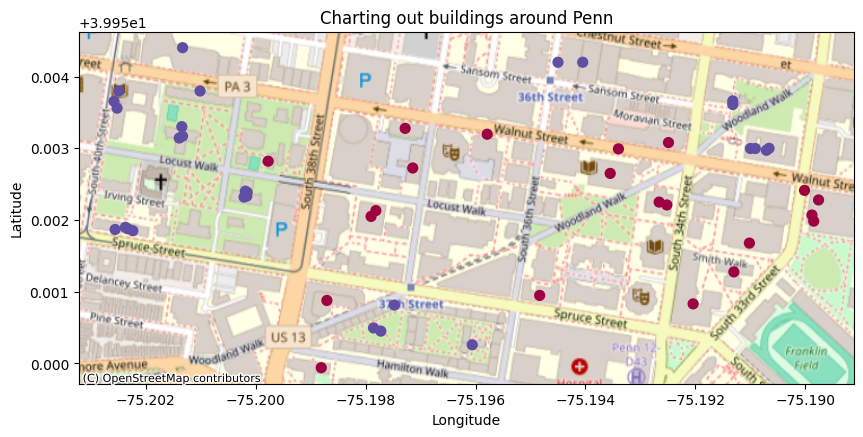

In [86]:
# prompt: superimpose a scatter plot of street addresses over a map of philadelphia

# !pip install geopandas contextily

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Replace with your actual data
# Assuming you have a CSV file with 'address' and 'latitude', 'longitude' columns
data = df

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf.crs = 'EPSG:4326'  # Set the coordinate system to WGS 84

# Plot the map
# ax = gdf.plot(figsize=(10, 10), markersize=50, color='red')
ax = gdf.plot(figsize=(10, 10), markersize=50, column='survey_label', cmap = 'Spectral', legend=False)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot (optional)
plt.title('Charting out buildings around Penn')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Next we need to stick this data into a pytorch tensor. You'll see here what's so nice about pandas - we can easily grab different inputs/outputs from the database and drop them in.

We will want to find a model that predicts *survey_label* from *latitude* and *longitude*. That means that X_in (the input to the model) should be a size [Ndata,2] tensor, and we should process the survey_labels into a size [Ndata,2] one-hot tensor.

As mentioned in last class, we always want to rescale our data so that the inputs of neural networks are between 0 and 1, or gradient descent won't work well.

In [87]:
# prompt: load latitude and longitude into pytorch tensor
import numpy as np
import torch

# Assuming your DataFrame 'df' has 'latitude' and 'longitude' columns
X_in = torch.tensor(df[['latitude', 'longitude']].values,dtype=torch.float32)
y_data = torch.tensor(df['survey_label'].values)

# Rescale X_in to [0,1]
datamin = X_in.min(dim=0)[0]
datamax = X_in.max(dim=0)[0]
X_in = (X_in - datamin) / (datamax - datamin)

#convert to one-hot encoding, considering we have 2 classes
y_data_onehot = torch.zeros(y_data.shape[0],2)
y_data_onehot[torch.arange(y_data.shape[0]),y_data.long()] = 1

print("Latitude Tensor:", X_in[:,0])
print("Longitude Tensor:", X_in[:,1])
print('One hot of classes:', y_data_onehot)

Latitude Tensor: tensor([0.7034, 0.4726, 0.5179, 0.8333, 0.4350, 0.5333, 0.4385, 0.6239, 0.5479,
        0.5538, 0.6855, 0.2256, 0.7530, 0.2000, 0.5368, 0.0718, 0.9547, 0.4581,
        0.8650, 0.4325, 0.8650, 0.8325, 0.9547, 0.6846, 0.5521, 0.1957, 0.6453,
        0.5239, 0.4769, 0.8111, 0.4915, 0.2991, 0.6855, 0.4282, 0.7239, 0.6795,
        0.8222, 0.1248, 0.6068, 0.7299, 0.7179, 0.1145, 0.5085, 1.0000, 0.2103,
        0.0000, 0.6838, 0.3897, 0.7479])
Longitude Tensor: tensor([0.7869, 0.3649, 0.7738, 0.8780, 0.0190, 0.1845, 0.0161, 0.4238, 0.1887,
        0.9798, 0.9101, 0.6042, 0.0964, 0.8220, 0.1887, 0.5083, 0.6298, 0.9929,
        0.1220, 0.0018, 0.0065, 0.0000, 0.6649, 0.9030, 0.1863, 0.3976, 0.2190,
        1.0000, 0.9905, 0.0042, 0.3714, 0.8798, 0.9298, 0.0268, 0.0970, 0.9256,
        0.8780, 0.3685, 0.7042, 0.5298, 0.0923, 0.3786, 0.7845, 0.0976, 0.3018,
        0.2940, 0.7161, 0.9018, 0.4131])
One hot of classes: tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [

## Step 2 - Build PyTorch model ##

We can copy and paste from one of the classification example networks in the last class. For this example, we need to take in two inputs and output two class labels. I made a neural network with *two hidden layers* - this will be more powerful than the single hidden layer we've used so far.

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class dorm_ClassificationMLP(nn.Module):
    def __init__(self):
        super(dorm_ClassificationMLP, self).__init__()
        self.Nneurons = 40                        # **ten** internal neurons
        self.hidden = nn.Linear(2, self.Nneurons) # **two** input neurons
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(self.Nneurons, self.Nneurons) # **ten** input to **ten** output
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(self.Nneurons, 2) # **two** output neurons
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.output(self.relu2(self.hidden2(self.relu(self.hidden(x))))))

## Step 3 - Initialize model and optimizer ##

This part is standard - just copied and pasted again from last class.

In [90]:
#Initialize the model
model = dorm_ClassificationMLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Step 4 - Train the model ##

Again - this is standard and copied from the last class examples.

In [92]:

num_epochs = 100000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_out = model(X_in)
    loss = criterion(y_out, y_data_onehot)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 0.35410189628601074
Epoch: 100 Loss: 0.35409706830978394
Epoch: 200 Loss: 0.3540935516357422
Epoch: 300 Loss: 0.3540908992290497
Epoch: 400 Loss: 0.35408884286880493
Epoch: 500 Loss: 0.3540872037410736
Epoch: 600 Loss: 0.35408589243888855
Epoch: 700 Loss: 0.35408487915992737
Epoch: 800 Loss: 0.35408398509025574
Epoch: 900 Loss: 0.35408324003219604
Epoch: 1000 Loss: 0.35408270359039307
Epoch: 1100 Loss: 0.3540821075439453
Epoch: 1200 Loss: 0.3540817201137543
Epoch: 1300 Loss: 0.35408133268356323
Epoch: 1400 Loss: 0.3540809750556946
Epoch: 1500 Loss: 0.3540806770324707
Epoch: 1600 Loss: 0.3540804088115692
Epoch: 1700 Loss: 0.35408011078834534
Epoch: 1800 Loss: 0.354079931974411
Epoch: 1900 Loss: 0.3540797829627991
Epoch: 2000 Loss: 0.35407960414886475
Epoch: 2100 Loss: 0.3540794551372528
Epoch: 2200 Loss: 0.35407933592796326
Epoch: 2300 Loss: 0.3540792763233185
Epoch: 2400 Loss: 0.35407915711402893
Epoch: 2500 Loss: 0.3540790379047394
Epoch: 2600 Loss: 0.3540789484977722
E

## Step 5. Post-process results. ##

First of all, we'll check a few predictions and make sure that the output probability is similar to the training probability.

In [93]:
with torch.no_grad():
    y_out = model(X_in)
    for i in range(X_in.shape[0]):
        print('(predicted probability/true probability): ',y_out[i,:].detach().numpy(),y_data_onehot[i,:].detach().numpy())


(predicted probability/true probability):  [9.9999976e-01 2.2397069e-07] [1. 0.]
(predicted probability/true probability):  [1.0000000e+00 1.2451454e-10] [1. 0.]
(predicted probability/true probability):  [1.0000000e+00 4.3716873e-19] [1. 0.]
(predicted probability/true probability):  [4.5927824e-31 1.0000000e+00] [0. 1.]
(predicted probability/true probability):  [0. 1.] [0. 1.]
(predicted probability/true probability):  [3.375617e-10 1.000000e+00] [0. 1.]
(predicted probability/true probability):  [0. 1.] [0. 1.]
(predicted probability/true probability):  [1.00000000e+00 1.29175205e-17] [1. 0.]
(predicted probability/true probability):  [4.358673e-08 1.000000e+00] [0. 1.]
(predicted probability/true probability):  [9.9999988e-01 1.4936793e-07] [1. 0.]
(predicted probability/true probability):  [2.3852602e-08 1.0000000e+00] [0. 1.]
(predicted probability/true probability):  [1.0000000e+00 2.0338298e-08] [1. 0.]
(predicted probability/true probability):  [1.6442919e-09 1.0000000e+00] [

Next, I want to visualize the decision boundary that it's using to split dorms and non-dorms apart. To do this, I'm going to copy and paste the code from last class in order to build a contour plot with the data overlaid.

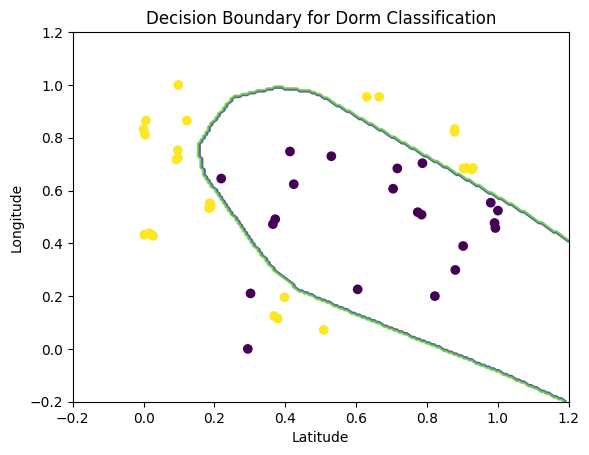

In [94]:
# Build a contour plot on a
x_min, x_max = X_in[:, 0].min() - 0.2, X_in[:, 0].max() + 0.2
y_min, y_max = X_in[:, 1].min() - 0.2, X_in[:, 1].max() + 0.2

#generate a grid of points between min and max
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 200), torch.linspace(y_min, y_max, 200))
X_grid = torch.stack([xx.flatten(), yy.flatten()], 1)

#calculate the model output for the grid
with torch.no_grad():
    y_out = model(X_grid)
    y_out = torch.argmax(y_out, dim=1)

# Create a contour plot
plt.contour(yy.numpy(), xx.numpy(), y_out.view(200, 200).numpy(), alpha=0.5)

# Add scatter plot of the data points (optional)
plt.scatter(X_in[:, 1].numpy(), X_in[:, 0].numpy(), c=y_data.numpy(), cmap='viridis')

# Add labels and title (optional)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Decision Boundary for Dorm Classification')

plt.show()


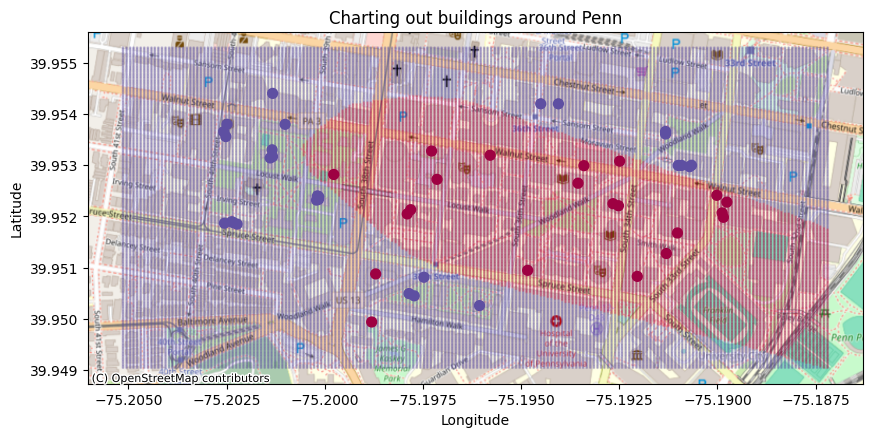

In [95]:
# Assuming you have a CSV file with 'address' and 'latitude', 'longitude' columns
data = df
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf.crs = 'EPSG:4326'  # Set the coordinate system to WGS 84

#Rescale the data back into lat/long coordinates and plot
scaledX = X_grid[:,0]*(datamax[0]-datamin[0])+datamin[0]
scaledY = X_grid[:,1]*(datamax[1]-datamin[1])+datamin[1]
contour_data = pd.DataFrame({'latitude': scaledX, 'longitude': scaledY, 'prediction': y_out.numpy()})
contour_gdf = gpd.GeoDataFrame(
    contour_data, geometry=gpd.points_from_xy(contour_data.longitude, contour_data.latitude))
contour_gdf.crs = 'EPSG:4326'

# # Plot the map with the contour plot superimposed
ax = contour_gdf.plot(figsize=(10,10), markersize=1, column='prediction', cmap='Spectral', alpha=0.3, legend=False)
gdf.plot(ax=ax, markersize=50, column='survey_label', cmap='Spectral', legend=False)

# # Add a basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# # Customize plot (optional)
plt.title('Charting out buildings around Penn')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

We can also plot the decision boundary more explicitly in the unscaled coordinates so we can compare more easily to the map.

[39.95308 39.95205 39.95225 39.95366 39.95188 39.95232]


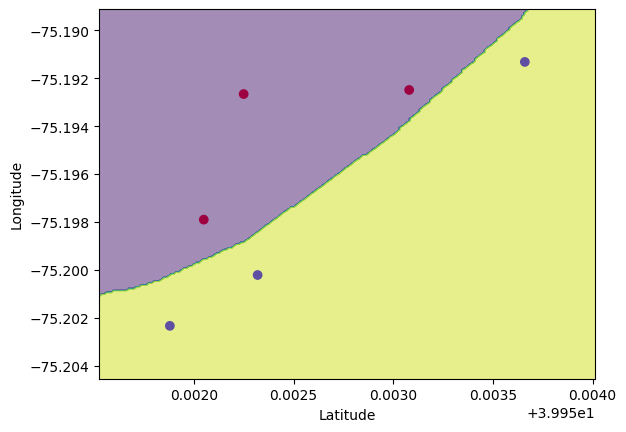

In [60]:
# Generate contours of decision boundary
scaledxx = (xx*(datamax[0]-datamin[0])+datamin[0]).numpy()
scaledyy = (yy*(datamax[1]-datamin[1])+datamin[1]).numpy()
plt.contourf(scaledxx, scaledyy, y_out.view(200, 200).numpy(), alpha=0.5)

print(data['latitude'].values)
plt.scatter(data['latitude'].values, data['longitude'].values, c=y_data.numpy(), cmap='Spectral')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
